# Predict Online News Popularity
### Group Member: Xiao Chu, Zhentao Hou, Jingwen Yu
<br></br>

In [1]:
# general imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from rfpimp import *

from sklearn.linear_model import LassoCV, RidgeCV, LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score, mean_absolute_error, median_absolute_error, accuracy_score, precision_score,\
                            recall_score, f1_score, confusion_matrix, classification_report
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', 62)

# Load Data

In [2]:
# load data
news = pd.read_csv("../raw_data/OnlineNewsPopularity.csv")

# delete the white space before each column name
news.columns = [col.strip() for col in news.columns]
news.head()

,url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,average_token_length,num_keywords,data_channel_is_lifestyle,data_channel_is_entertainment,data_channel_is_bus,data_channel_is_socmed,data_channel_is_tech,data_channel_is_world,kw_min_min,kw_max_min,kw_avg_min,kw_min_max,kw_max_max,kw_avg_max,kw_min_avg,kw_max_avg,kw_avg_avg,self_reference_min_shares,self_reference_max_shares,self_reference_avg_sharess,weekday_is_monday,weekday_is_tuesday,weekday_is_wednesday,weekday_is_thursday,weekday_is_friday,weekday_is_saturday,weekday_is_sunday,is_weekend,LDA_00,LDA_01,LDA_02,LDA_03,LDA_04,global_subjectivity,global_sentiment_polarity,global_rate_positive_words,global_rate_negative_words,rate_positive_words,rate_negative_words,avg_positive_polarity,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares
0,http://mashable.com/2013/01/07/amazon-instant-...,731.0,12.0,219.0,0.663594,1.0,0.815385,4.0,2.0,1.0,0.0,4.680365,5.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,496.0,496.0,496.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.500331,0.378279,0.040005,0.041263,0.040123,0.521617,0.092562,0.045662,0.013699,0.769231,0.230769,0.378636,0.100000,0.7,-0.350000,-0.600,-0.200000,0.500000,-0.187500,0.000000,0.187500,593
1,http://mashable.com/2013/01/07/ap-samsung-spon...,731.0,9.0,255.0,0.604743,1.0,0.791946,3.0,1.0,1.0,0.0,4.913725,4.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.799756,0.050047,0.050096,0.050101,0.050001,0.341246,0.148948,0.043137,0.015686,0.733333,0.266667,0.286915,0.033333,0.7,-0.118750,-0.125,-0.100000,0.000000,0.000000,0.500000,0.000000,711
2,http://mashable.com/2013/01/07/apple-40-billio...,731.0,9.0,211.0,0.575130,1.0,0.663866,3.0,1.0,1.0,0.0,4.393365,6.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,918.0,918.0,918.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.217792,0.033334,0.033351,0.033334,0.682188,0.702222,0.323333,0.056872,0.009479,0.857143,0.142857,0.495833,0.100000,1.0,-0.466667,-0.800,-0.133333,0.000000,0.000000,0.500000,0.000000,1500
3,http://mashable.com/2013/01/07/astronaut-notre...,731.0,9.0,531.0,0.503788,1.0,0.665635,9.0,0.0,1.0,0.0,4.404896,7.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.028573,0.419300,0.494651,0.028905,0.028572,0.429850,0.100705,0.041431,0.020716,0.666667,0.333333,0.385965,0.136364,0.8,-0.369697,-0.600,-0.166667,0.000000,0.000000,0.500000,0.000000,1200
4,http://mashable.com/2013/01/07/att-u-verse-apps/,731.0,13.0,1072.0,0.415646,1.0,0.540890,19.0,19.0,20.0,0.0,4.682836,7.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,545.0,16000.0,3151.157895,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.028633,0.028794,0.028575,0.028572,0.885427,0.513502,0.281003,0.074627,0.012127,0.860215,0.139785,0.411127,0.033333,1.0,-0.220192,-0.500,-0.050000,0.454545,0.136364,0.045455,0.136364,505


# Exploratory Data Analysis

## Target Exploration

Since the range of number of shares is too large, we decided to perform a log transformation and then check the distribution.

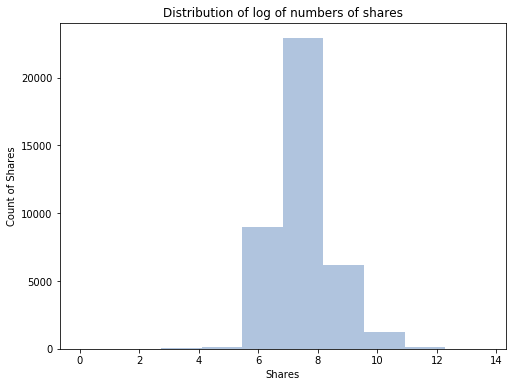

In [3]:
# choose features and target
X = news.iloc[:, 2:60]  # all columns except url and target
y = news["shares"].values.ravel()  # target: number of shares

plt.figure(figsize=(8, 6))
plt.hist(np.log(y), color='lightsteelblue')
plt.xlabel("Shares")
plt.ylabel("Count of Shares")
plt.title("Distribution of log of numbers of shares")
# plt.savefig(fname="Distribution of log of numbers of shares.jpg", dpi=400)
plt.show()

## Feature Exploration

First, we checked the feature correlation heatmap and most of the features are uncorrelated.

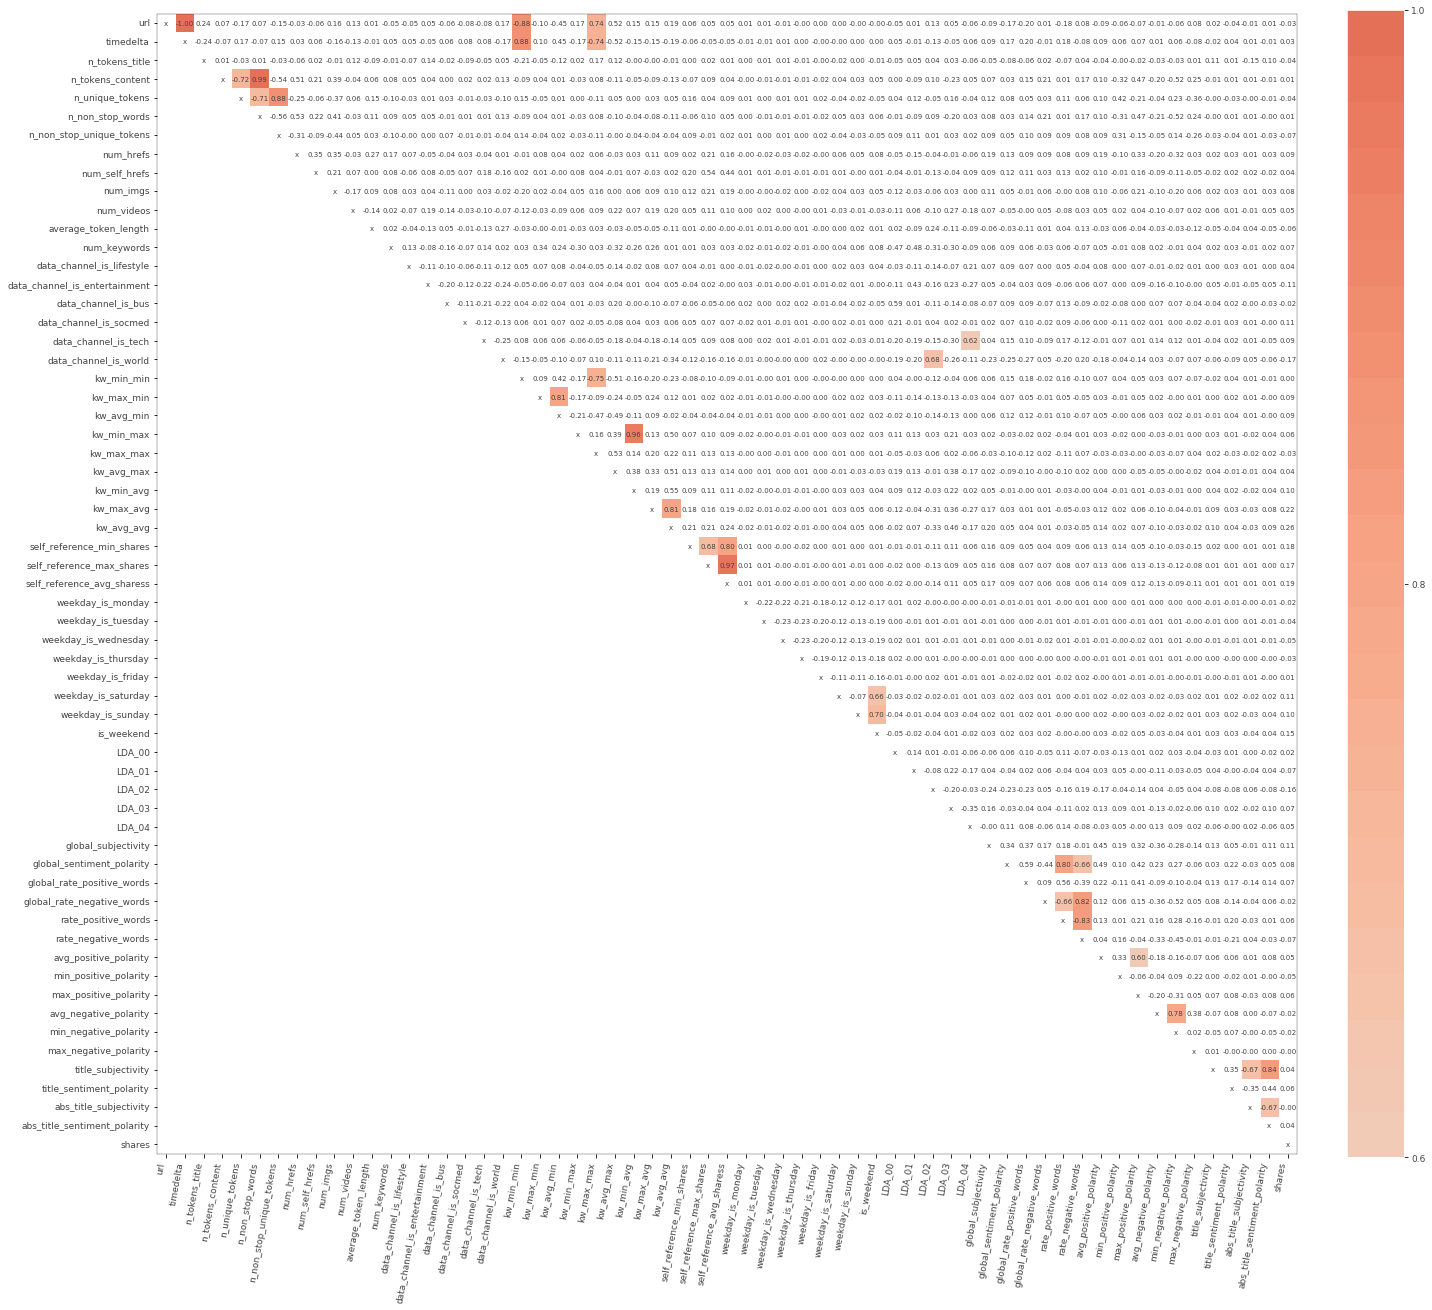

In [4]:
# plot the feature correlation heatmap
corr = plot_corr_heatmap(news, figsize=(20, 20), label_fontsize=9, value_fontsize=7)  # from rfpimp package
corr.view()

Then, we explored the relationship between the target (number of shares) and some selected features:
1. number of words in the content vs number of shares
2. text sentiment polarity vs number of shares

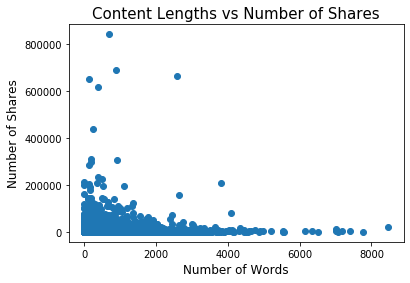

In [5]:
# number of words in the content vs number of shares
plt.scatter(news["n_tokens_content"], news["shares"])
plt.title("Content Lengths vs Number of Shares", size=15)
plt.xlabel("Number of Words", size=12)
plt.ylabel("Number of Shares", size=12)
plt.show()

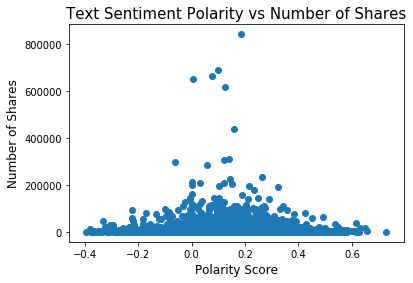

In [6]:
# text sentiment polarity vs number of shares
plt.scatter(news["global_sentiment_polarity"], news["shares"])
plt.title("Text Sentiment Polarity vs Number of Shares", size=15)
plt.xlabel("Polarity Score", size=12)
plt.ylabel("Number of Shares", size=12)
plt.show()

# Modeling

## Part (a). Regression
<p style='text-align: justify;'>Initially, regression models were used to predict the number of shares of a piece of news. All features except for news url and timedelta were included in the model. StandardScaler() was applied to numerical features. Pipelines were created for each regression algorithm.</p>

In [7]:
# choose features and target
X = news.iloc[:, 2:60]  # all columns except url and target
y = news["shares"].values.ravel()  # target: number of shares

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

In [8]:
# function to create pipelines for different regression algorithms
def regr_pipeline():
    """
    Create a pipeline for each regression algorithm:
    1. Lasso
    2. Ridge
    3. Random Forest Regressor
    
    Use StandardScaler() on numerical features if necessary.
    Return a list of pipelines.
    """
    num_indices = list(range(11)) + list(range(17, 29)) + list(range(37, 58))  # numerical feature indices
    num_transformer = Pipeline(steps=[("scaler", StandardScaler())])
    preprocessor = ColumnTransformer(transformers=[("num", num_transformer, num_indices)], remainder="passthrough")
    
    lasso = Pipeline(steps=[("preprocessor", preprocessor),
                            ("regressor", LassoCV(cv=5, max_iter=500))])
    ridge = Pipeline(steps=[("preprocessor", preprocessor), ("regressor", RidgeCV(cv=5))])
    rf_regr = Pipeline(steps=[("regressor", RandomForestRegressor(n_estimators=100))])
    pipelines = [lasso, ridge, rf_regr]
    return pipelines

In [9]:
# fit models with train data
# look at model performance on test data
# evaluation metrics include r^2, mean absolute error and median absolute error
regr_pipelines = regr_pipeline()
regr_eval = []

for pipeline in regr_pipelines:
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    
    model_name = pipeline.named_steps['regressor'].__class__.__name__.split('.')[-1]
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    medae = median_absolute_error(y_test, y_pred)
    regr_eval.append([model_name, r2, mae, medae])

In [10]:
# store evaluation metrics in a dataframe
# look at evaluation metrics
regr_eval = pd.DataFrame(regr_eval)
regr_eval.columns = ["model", "r2", "mean absolute error", "median absolute error"]
regr_eval

,model,r2,mean absolute error,median absolute error
0,LassoCV,0.022728,3108.931379,1653.074208
1,RidgeCV,0.022448,3118.265139,1655.898382
2,RandomForestRegressor,-0.074845,3549.834637,1571.090000


## Part (b). Binary Classification
<p style='text-align: justify;'>Using regression models resulted in large median absolute errors, so we thought classification models may actually make more sense for this problem. All features except for news url and timedelta were included in the model. StandardScaler() was applied to numerical features. Pipelines were created for each classification algorithm.</p>

### Distribution with Different Thresholds

In [11]:
# add a column with two classes (by median), 0 for unpopular (shares <= 1400) and 1 for popular (shares > 1400)
median = np.median(news["shares"])
news_binary_median = news.assign(popularity=0)
news_binary_median.loc[news_binary_median["shares"] > median, "popularity"] = 1

# add a column with two classes (by mean), 0 for unpopular (shares <= 3395) and 1 for popular (shares > 3395)
mean = np.mean(news["shares"])
news_binary_mean = news.assign(popularity=0)
news_binary_mean.loc[news_binary_median["shares"] > mean, "popularity"] = 1

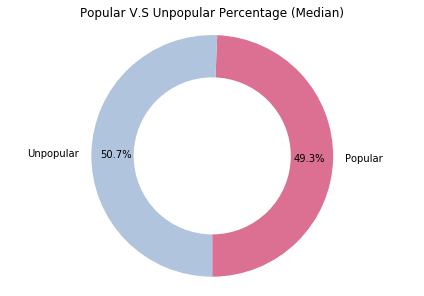

<Figure size 432x288 with 0 Axes>

In [12]:
# pie chart of popular and unpopular news distribution using the median number of shares as threshold
x = ['Popular', 'Unpopular']
num = [19562, 20082]
colors = ['palevioletred', 'lightsteelblue']

fig1, ax1 = plt.subplots()
ax1.pie(num, colors=colors, labels=x, autopct='%1.1f%%', startangle=270, pctdistance=0.8)
centre_circle = plt.Circle((0, 0), 0.65, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
ax1.axis('equal')
plt.tight_layout()
plt.title("Popular V.S Unpopular Percentage (Median)")
plt.show()
# plt.savefig('popularvsunpopular_median.jpg', dpi=400)

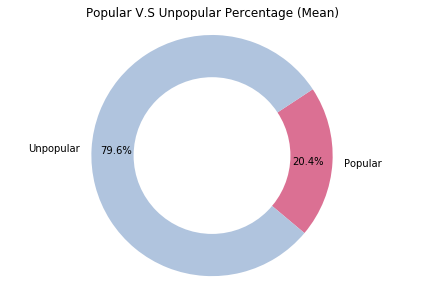

<Figure size 432x288 with 0 Axes>

In [13]:
# pie chart of popular and unpopular news distribution using the mean number of shares as threshold
x_mean = ['Popular', 'Unpopular']
num_mean = [8079, 31565]
colors = ['palevioletred', 'lightsteelblue']

fig1, ax1 = plt.subplots()
ax1.pie(num_mean, colors=colors, labels=x_mean, autopct='%1.1f%%', startangle=320, pctdistance=0.8)
centre_circle = plt.Circle((0, 0), 0.65, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
ax1.axis('equal')
plt.tight_layout()
plt.title("Popular V.S Unpopular Percentage (Mean)")
plt.show()
# plt.savefig('popularvsunpopular_mean.jpg', dpi=400)

<p style='text-align: justify;'>If the mean number of shares (3395) is used as the threshold, the popular and unpopular classes would be imbalanced. Additionally, the large range of number of shares would make the mean not appropriate to divide the news into two classes. Therefore, we decided to choose the median number of shares (1400) as the threshold.</p>

### EDA for Classification

Bar chart showing the number of class instances over different day of week

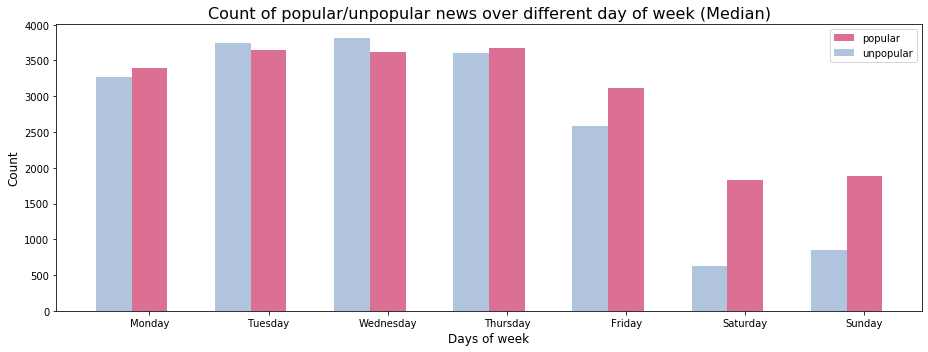

In [14]:
# select columns for the bar chart
wd = news.columns.values[31:38]
wd2 = np.array(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

# bar chart
unpop2 = news[news['shares'] < median]
pop2 = news[news['shares'] >= median]
unpop_day2 = unpop2[wd].sum().values
pop_day2 = pop2[wd].sum().values

fig = plt.figure(figsize=(13, 5))
plt.title("Count of popular/unpopular news over different day of week (Median)", fontsize=16)
plt.bar(np.arange(len(wd)), pop_day2, width=0.3, align="center", color='palevioletred', label="popular")
plt.bar(np.arange(len(wd)) - 0.3, unpop_day2, width=0.3, align="center", color='lightsteelblue', label="unpopular")

plt.xticks(np.arange(len(wd)), wd2)
plt.ylabel("Count", fontsize=12)
plt.xlabel("Days of week", fontsize=12)
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

Bar chart showing the number of class instances over different data channels

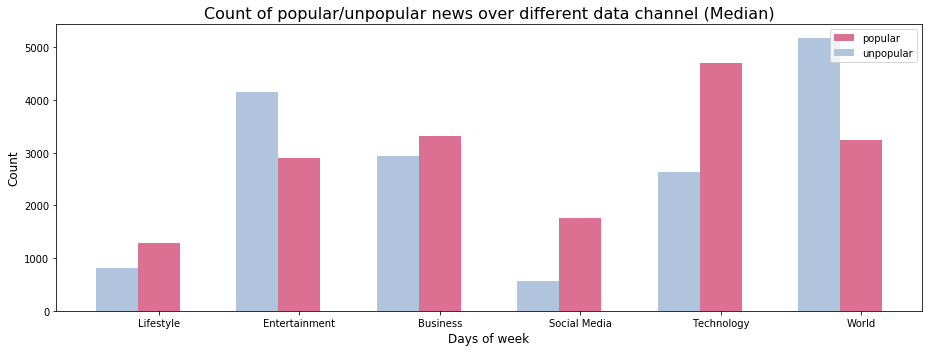

In [15]:
# select columns for the bar chart
dc = news.columns.values[13:19]
dc2 = np.array(['Lifestyle', 'Entertainment', 'Business', 'Social Media', 'Technology', 'World'])

# bar chart
unpop4 = news[news['shares'] < median]
pop4 = news[news['shares'] >= median]
unpop_day4 = unpop4[dc].sum().values
pop_day4 = pop4[dc].sum().values

fig = plt.figure(figsize=(13, 5))
plt.title("Count of popular/unpopular news over different data channel (Median)", fontsize=16)
plt.bar(np.arange(len(dc)), pop_day4, width=0.3, align="center", color='palevioletred', label="popular")
plt.bar(np.arange(len(dc)) - 0.3, unpop_day4, width=0.3, align="center", color='lightsteelblue', label="unpopular")

plt.xticks(np.arange(len(dc)), dc2)
plt.ylabel("Count", fontsize=12)
plt.xlabel("Days of week", fontsize=12)
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

### Use the median number of shares as threshold

In [16]:
# add a column with two classes, 0 for unpopular (shares <= 1400) and 1 for popular (shares > 1400)
median = np.median(news["shares"])
news_binary_median = news.assign(popularity=0)
news_binary_median.loc[news_binary_median["shares"] > median, "popularity"] = 1

In [17]:
# choose features and target
X = news_binary_median.iloc[:, 2:60]  # all columns except url, timedelta and target
y = news_binary_median["popularity"].values.ravel()  # target: popularity (two classes, 0 and 1)

# train test split using 80-20 rule
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

### Build Pipelines

In [18]:
# function to create pipelines for different classification algorithms
def clf_pipeline():
    """
    Create a pipeline for each classification algorithm:
    1. Logistic Regression
    2. K-Nearest Neighbors
    3. Naive Bayes
    4. Random Forest Classifier
    
    Use StandardScaler() on numerical features if necessary.
    Return a list of pipelines.
    """
    num_indices = list(range(11)) + list(range(17, 29)) + list(range(37, 58))  # numerical feature indices
    num_transformer = Pipeline(steps=[("scaler", StandardScaler())])
    preprocessor = ColumnTransformer(transformers=[("num", num_transformer, num_indices)], remainder="passthrough")
    
    logistic = Pipeline(steps=[("preprocessor", preprocessor),
                               ("clf", LogisticRegressionCV(cv=5, max_iter=250, solver="lbfgs"))])
    knn = Pipeline(steps=[("preprocessor", preprocessor), ("clf", KNeighborsClassifier())])
    bayes = Pipeline(steps=[("preprocessor", preprocessor), ("clf", GaussianNB())])
    rf_clf = Pipeline(steps=[("clf", RandomForestClassifier(n_estimators=100))])
    pipelines = [logistic, knn, bayes, rf_clf]
    return pipelines

### Fit Models

In [19]:
# fit models with train data
# look at model performance on test data
# evaluation metrics include accuracy, precision, recall, f1 score, confusion_matrix and classification report
clf_pipelines = clf_pipeline()
clf_eval = []

for pipeline in clf_pipelines:
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    
    model_name = pipeline.named_steps['clf'].__class__.__name__.split('.')[-1]
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average="weighted")
    conf_mat = confusion_matrix(y_test, y_pred)
    clf_report = classification_report(y_test, y_pred)
    clf_eval.append([model_name, accuracy, precision, recall, f1, conf_mat, clf_report])

# store evaluation metrics in a dataframe
clf_eval = pd.DataFrame(clf_eval)
clf_eval.columns = ["model", "accuracy", "precision", "recall", "f1 score", "confusion matrix",
                    "classification report"]

### Evaluation Metrics

In [20]:
# look at model accuracy, precision, recall and F1 score of test data
clf_eval[["model", "accuracy", "precision", "recall", "f1 score"]]

,model,accuracy,precision,recall,f1 score
0,LogisticRegressionCV,0.652037,0.667392,0.614690,0.651573
1,KNeighborsClassifier,0.595409,0.615567,0.521434,0.593196
2,GaussianNB,0.525413,0.678797,0.107546,0.423918
3,RandomForestClassifier,0.663261,0.676573,0.633492,0.662982


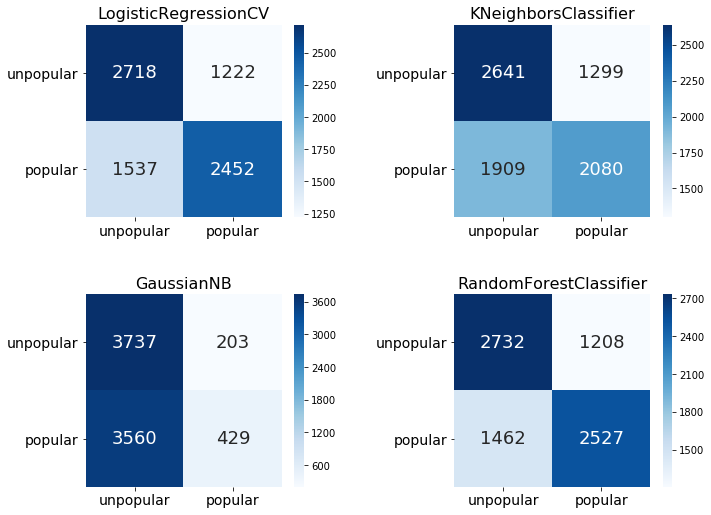

In [21]:
# look at model confusion matrix of test data
plt.figure(figsize=(11, 8.5))
for idx in range(4):
    plt.subplot(2, 2, idx + 1)
    plt.subplots_adjust(wspace=0.5, hspace=0.4)
    ax = sns.heatmap(clf_eval["confusion matrix"][idx], cmap="Blues", annot=True, annot_kws={"size": 18}, fmt="d")
    ax.set_title(f"{clf_eval['model'][idx]}", size=16)
    ax.xaxis.set_ticklabels(["unpopular", "popular"], size=14)
    ax.yaxis.set_ticklabels(["unpopular", "popular"], size=14, rotation=0)

### Hyperparameter Tuning
<p style='text-align: justify;'>Grid search and random search were too slow for this dataset. Instead, we used cross validation with cv = 5 and manually tuned some hyperparameters of the random forest classifier, including n_estimators, min_samples_leaf, and max_features.</p>

In [22]:
# tune n_estimators
for num in range(10, 140, 20):
    rf = RandomForestClassifier(n_estimators=num)
    scores = cross_val_score(rf, X_train, y_train, cv=5, scoring="f1_weighted")
    print(f"n_estimators: {num}, cross validation scores: {scores}")

n_estimators: 10, cross validation scores: [0.62575363 0.62041321 0.6111905  0.61290906 0.61280958]
n_estimators: 30, cross validation scores: [0.65720208 0.63665237 0.64878461 0.64660654 0.65134069]
n_estimators: 50, cross validation scores: [0.65635099 0.64707475 0.64420018 0.65377432 0.66359343]
n_estimators: 70, cross validation scores: [0.66290505 0.646573   0.65500068 0.65941396 0.65981835]
n_estimators: 90, cross validation scores: [0.66326903 0.65795831 0.65916686 0.65621492 0.66686236]
n_estimators: 110, cross validation scores: [0.66588697 0.6547945  0.65487535 0.65652519 0.66055739]
n_estimators: 130, cross validation scores: [0.67158237 0.6553164  0.65463169 0.6585001  0.66090608]


In [23]:
# choose n_estimators = 110
# tune max_features
for num in range(4, 9, 1):
    rf = RandomForestClassifier(n_estimators=110, max_features=num)
    scores = cross_val_score(rf, X_train, y_train, cv=5, scoring="f1_weighted")
    print(f"max_features: {num}, cross validation scores: {scores}")

max_features: 4, cross validation scores: [0.66256958 0.65476857 0.6585808  0.65773993 0.66743569]
max_features: 5, cross validation scores: [0.66640541 0.65424672 0.65926487 0.66424204 0.66213029]
max_features: 6, cross validation scores: [0.66510062 0.65186016 0.66007797 0.66503943 0.66306302]
max_features: 7, cross validation scores: [0.66657975 0.65307702 0.65939091 0.66059243 0.66574694]
max_features: 8, cross validation scores: [0.66894861 0.65015122 0.6566217  0.66274283 0.65798047]


In [24]:
# choose n_estimators = 110 and max_features = 5
# tune min_samples_leaf
for num in range(1, 9, 2):
    rf = RandomForestClassifier(n_estimators=110, max_features=5, min_samples_leaf=num)
    scores = cross_val_score(rf, X_train, y_train, cv=5, scoring="f1_weighted")
    print(f"min_samples_leaf: {num}, cross validation scores: {scores}")

min_samples_leaf: 1, cross validation scores: [0.66687997 0.65545866 0.65584983 0.6622161  0.66018908]
min_samples_leaf: 3, cross validation scores: [0.66630339 0.65904494 0.66384266 0.66487255 0.66002656]
min_samples_leaf: 5, cross validation scores: [0.67262578 0.6546225  0.65711887 0.65757567 0.66853923]
min_samples_leaf: 7, cross validation scores: [0.67136483 0.65148269 0.66055206 0.6572726  0.6658438 ]


<p style='text-align: justify;'>Based on the results of manually tuning, we noticed that tuning max_features and min_samples_leaf gave very similar results when varying the numbers. Considering the combination of F1 score and efficiency, we decided to choose n_estimators = 100, max_features = 5, and min_samples_leaf = 7 for our final model.</p>

## Part (c). Final Model

In [25]:
# fit final model with train data
final_model = RandomForestClassifier(n_estimators=110, max_features=5, min_samples_leaf=7)
final_model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features=5, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=7, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=110,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [26]:
# North Star Metric: F1 Score
# performance on test data
y_pred = final_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print(f"Accuracy: {accuracy}, F1 Score: {f1}")

Accuracy: 0.6649009963425401, F1 Score: 0.6567626921586358


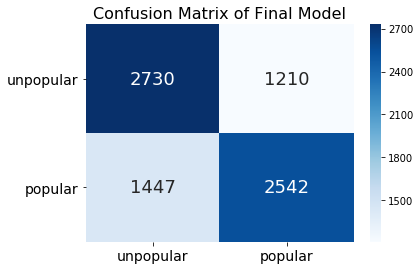

In [27]:
# visualize the confusion matrix
conf_mat = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(conf_mat, cmap="Blues", annot=True, annot_kws={"size": 18}, fmt="d")
ax.set_title(f"Confusion Matrix of Final Model", size=16)
ax.xaxis.set_ticklabels(["unpopular", "popular"], size=14)
ax.yaxis.set_ticklabels(["unpopular", "popular"], size=14, rotation=0)
plt.show()

## Feature Importance

In [28]:
# extract feature importance 
imp = importances(final_model, X_test, pd.DataFrame(y_test))

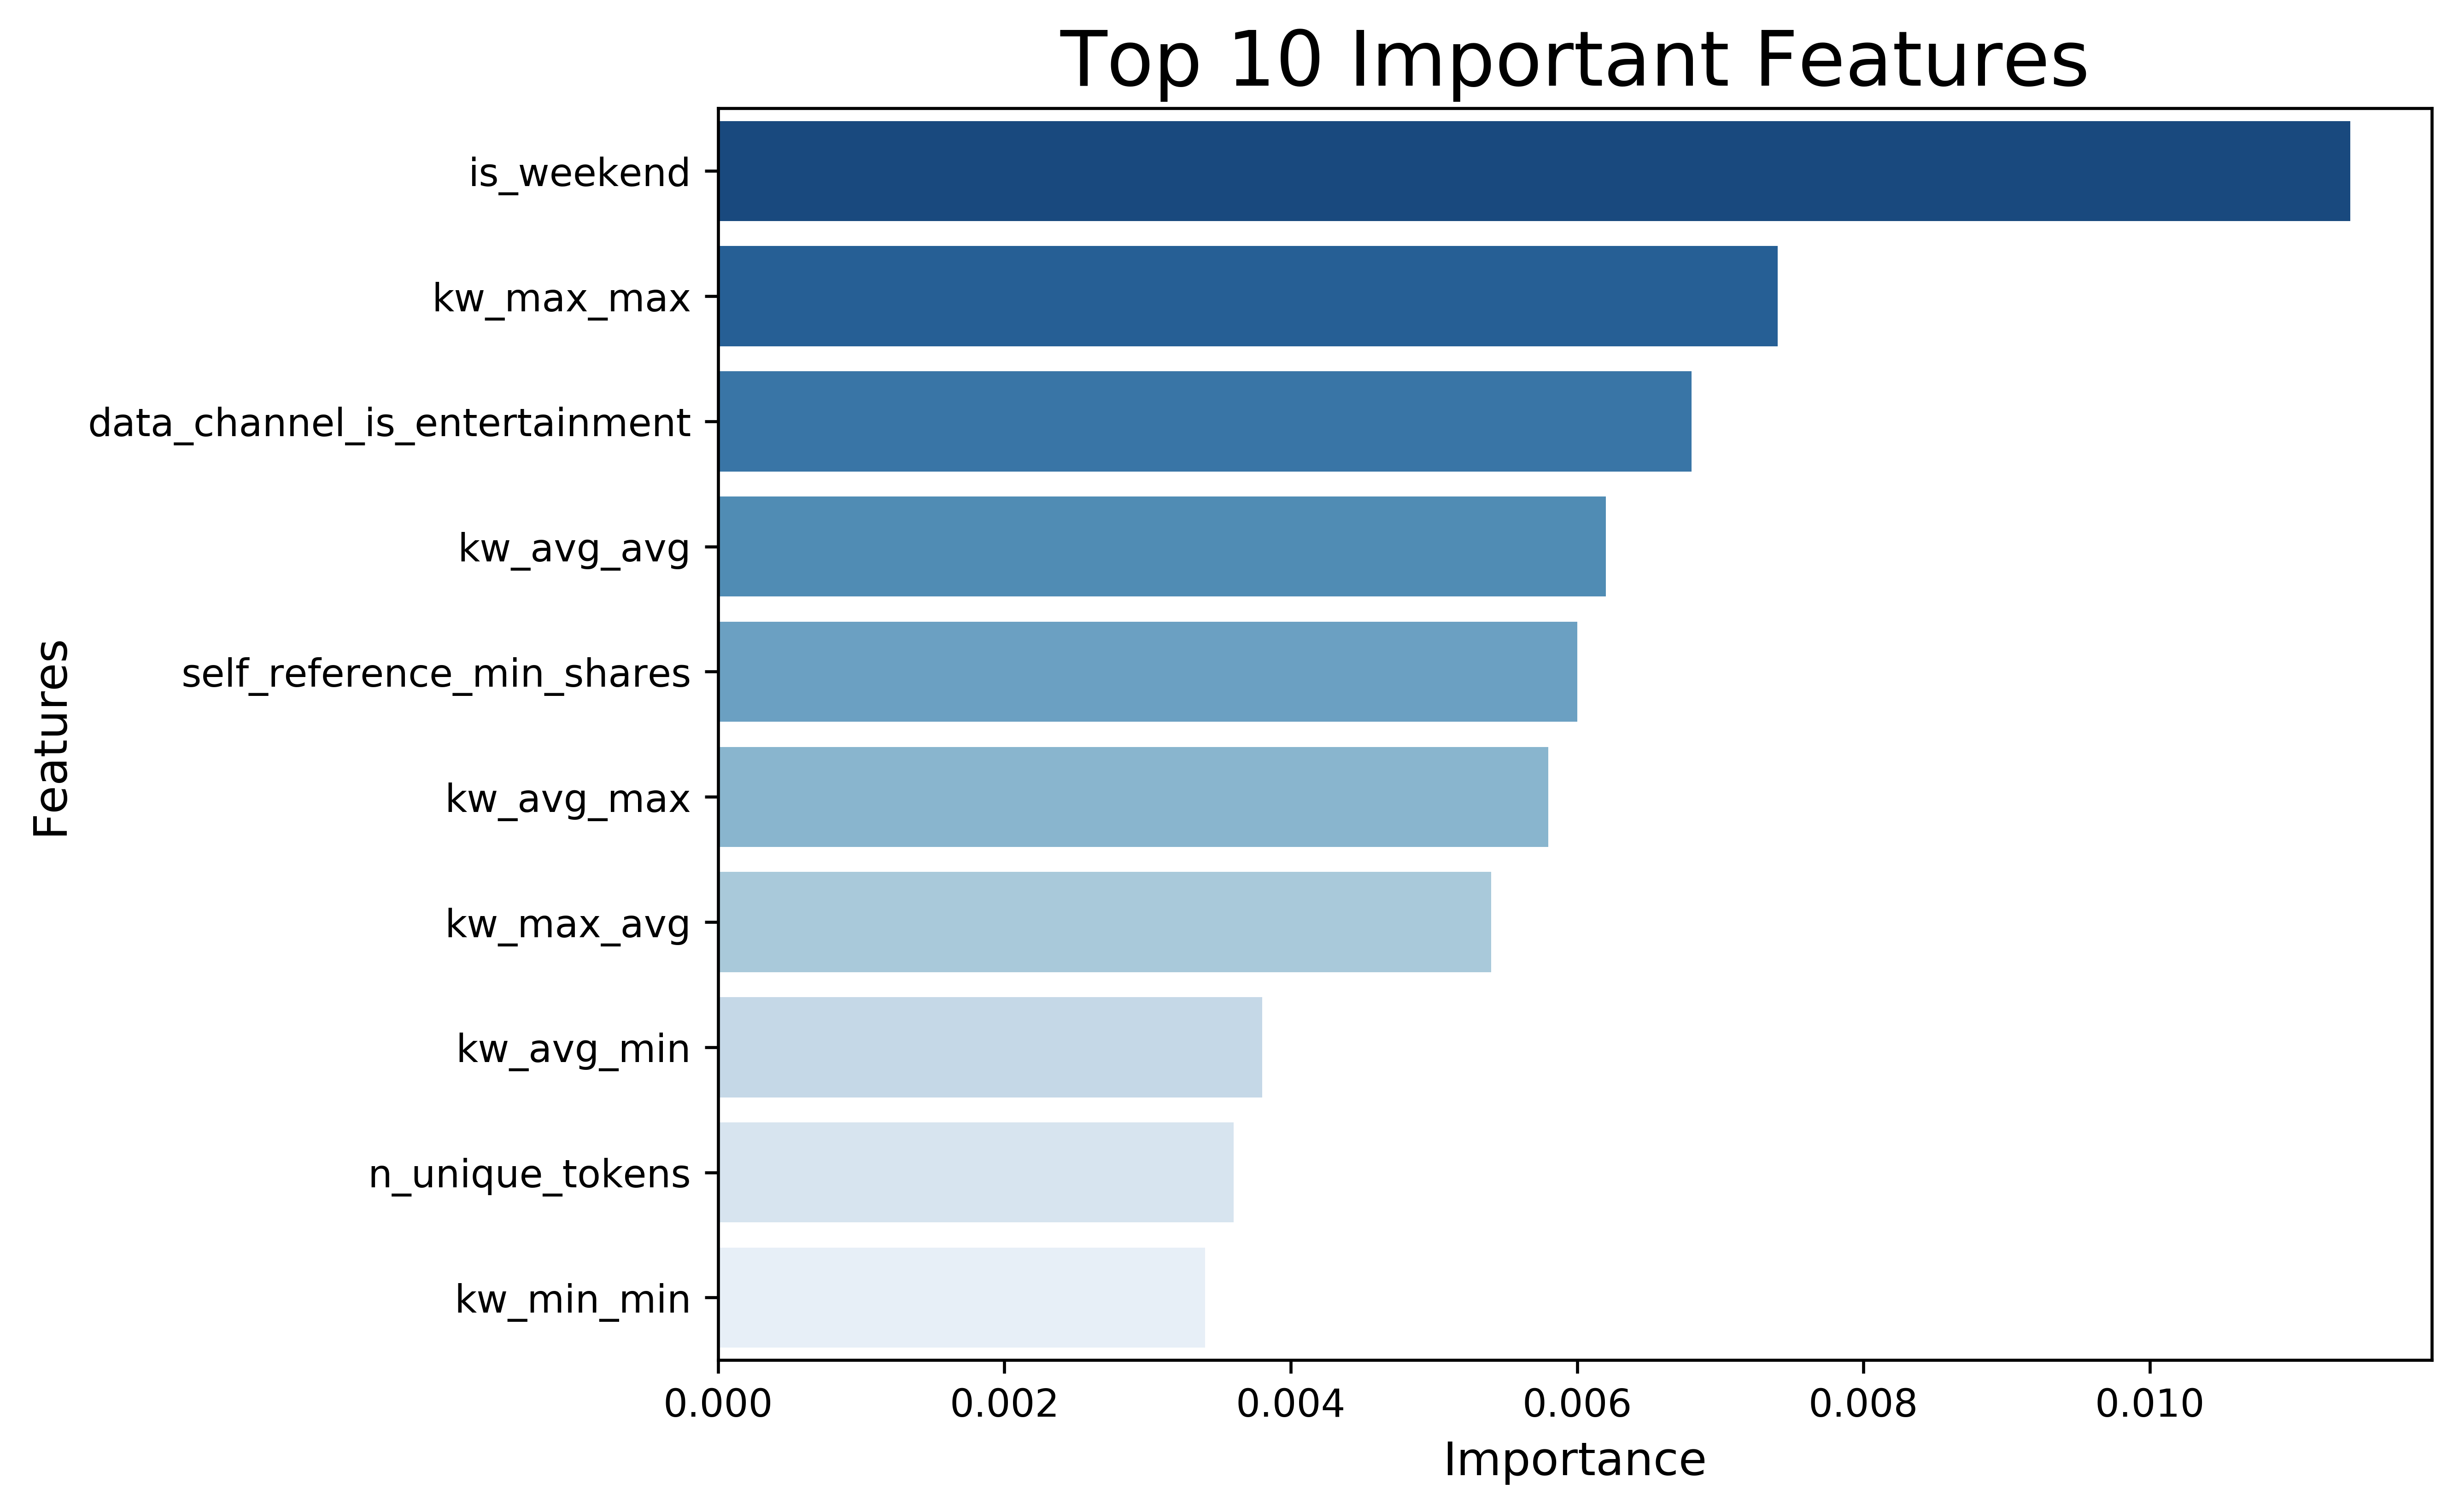

In [29]:
# plot top 10 feature importance
imp_top10 = imp[:10].reset_index()

plt.figure(figsize=(8, 6), dpi=600)
sns.barplot(x="Importance", y="Feature", data=imp_top10, palette="Blues_r")
plt.title("Top 10 Important Features", size=20)
plt.xlabel("Importance", size=12)
plt.xticks(size=10)
plt.ylabel("Features", size=12)
plt.yticks(size=10)
plt.show()
# plt.savefig(fname="Importance Features.jpg", dpi=200)

# Summary
<p style='text-align: justify;'>For this project, we initially tried to predict the number of shares of a piece of news with regression models. We fit three algorithms, <b>Lasso</b>, <b>Ridge</b>, and <b>Random Forest Regressor</b>, and found that the median absolute error (MedAE) was around 1600, which is very high considering that some news only has a few hundred shares.</p>
<p style='text-align: justify;'>We then treated this problem as classification and used the median number of shares (1400) as a threshold to divide the news into two classes, popular and unpopular. We fit four algorithms, <b>Logistic Regression</b>, <b>K-Nearest Neighbors</b>, <b>Gaussian Naive Bayes</b>, and <b>Random Forest Classifier</b>, and found that <b>Random Forest Classifier</b> has the best performance using F1 score as the North Star Metric.</p>
<p style='text-align: justify;'>We manually tuned the hyperparameters of random forest classifier based on cross validation scores since grid/random search was too slow for this dataset. Our final model had a <b>F1 score of 0.66</b> and <b>accuracy of 66%</b> for the test data.</p>

# Takeaways
- Choose an appropriate analysis method (regression/classification)  
<br></br>
- Recommendations for reporters and business entities:  
    a. Keywords are important.  
    b. Publication time matters.  
    c. Referencing articles with high popularity would be helpful.